In [1]:
# 1. Import packages
import os,keras,cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import datetime
from keras import layers,losses,callbacks,activations,regularizers,metrics,applications,optimizers 

In [2]:
# 2. Data loading

PATH = os.path.join('Cat_Breed')

BATCH_SIZE = 32
IMG_SIZE = (160,160)

train_dataset,validation_dataset = keras.utils.image_dataset_from_directory(PATH,shuffle=True,
                                                                            validation_split=0.3,
                                                                            batch_size=BATCH_SIZE,
                                                                            image_size=IMG_SIZE,subset='both',
                                                                            seed=40)

Found 5499 files belonging to 11 classes.
Using 3850 files for training.
Using 1649 files for validation.


['Abyssinian', 'Bombay', 'Egyptian Mau', 'Exotic Shorthair', 'Himalayan', 'Maine Coon', 'Regdoll', 'Russian Blue', 'Scottish Fold', 'Siamese', 'Sphynx']


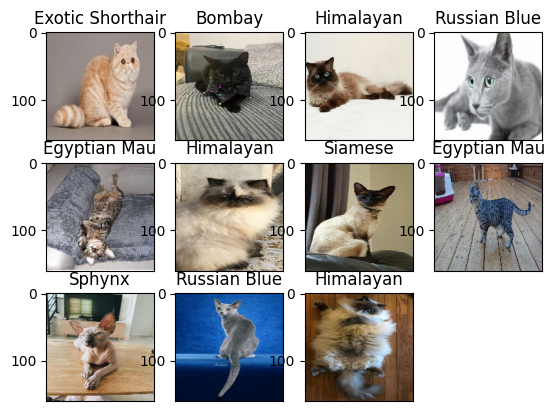

In [3]:
#3. Inspect some data samples from the dataset
class_names = train_dataset.class_names
print(class_names)
batch_1 = train_dataset.take(1)
for features,label in batch_1:
    for i in range(11):
        plt.subplot(3,4,i+1)
        plt.imshow(features[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.xticks([])
        plt.grid(False)
plt.show()

In [4]:
# 4. Split the validation dataset into 2 equal splits: for val and test
nBatches = validation_dataset.cardinality().numpy()
print(nBatches)
val_dataset = validation_dataset.take(nBatches*0.7)
test_dataset = validation_dataset.skip(nBatches//2)

52


In [5]:
# 5.Convert the val and test dataset back to PrefetchDataset
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [6]:
# 6. Create a sequential model for augmentation
data_augmentation = keras.Sequential()
data_augmentation.add(layers.RandomFlip())
data_augmentation.add(layers.RandomRotation(factor=0.2))

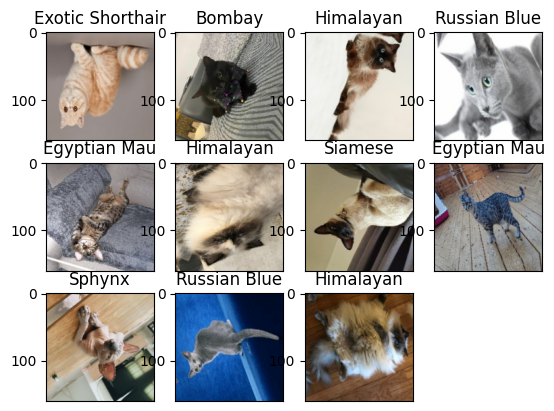

In [7]:
features_augmented = data_augmentation(features)
for i in range(11):
    plt.subplot(3,4,i+1)
    plt.imshow(features_augmented[i].numpy().astype('uint8'))
    plt.title(class_names[label[i]])
    plt.xticks([])
    plt.grid(False)
plt.show()

In [8]:
# Create the preprocessing layer based on the pretrained model that we will use
preprocess_input = applications.mobilenet_v2.preprocess_input

In [9]:
# 7. Applu Transfer learning
#(A) Load in the pretrained model as feature extractor
IMG_SHAPE = IMG_SIZE + (3,)
base_model = applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights="imagenet")
# Freeze the entire feature extractor to make sure we only train the classifier
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
#(B) Construct the classifier 
global_avg = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(len(class_names),activation='softmax')

In [11]:
#(C) Use functional API to connect all th layers together
#a. Begin with the input 
inputs = keras.Input(shape=IMG_SHAPE)
#b. Augmentation layers
x = data_augmentation(inputs)
#c.preprocessing layer
x = preprocess_input(x)
#d. Feature extractor
x = base_model(x)
#e.Classifier
x = global_avg(x)
outputs = output_layer(x)
#f. Create the model
model = keras.Model(inputs=inputs,outputs=outputs)
model.summary()
keras.utils.plot_model(model)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 11)             │        14,091 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,272,075 (8.67 MB)

 Trainable params: 14,091 (55.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [12]:
#8. Compile the model
optimizer = optimizers.Adam(learning_rate=0.0001)
loss = losses.SparseCategoricalCrossentropy()
history = model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

In [20]:
#Proceed with the training
EPOCHS = 10
history_first = model.fit(train_dataset,validation_data=val_dataset,epochs=EPOCHS)

Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 30s 217ms/step - accuracy: 0.7827 - loss: 0.6613 - val_accuracy: 0.8264 - val_loss: 0.5762
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 26s 218ms/step - accuracy: 0.8112 - loss: 0.5959 - val_accuracy: 0.8316 - val_loss: 0.5501
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 26s 212ms/step - accuracy: 0.8050 - loss: 0.5944 - val_accuracy: 0.8411 - val_loss: 0.5305
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 26s 217ms/step - accuracy: 0.8225 - loss: 0.5679 - val_accuracy: 0.8455 - val_loss: 0.5127
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 220ms/step - accuracy: 0.8310 - loss: 0.5494 - val_accuracy: 0.8481 - val_loss: 0.5001
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 226ms/step - accuracy: 0.8319 - loss: 0.5134 - val_accuracy: 0.8490 - val_loss: 0.4880
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 222ms/step - accuracy: 0.8249 - loss: 0.5375 - val_accuracy: 0.8568 - val_loss: 0.4760
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 219ms/step - accuracy: 0.8450 - loss: 0

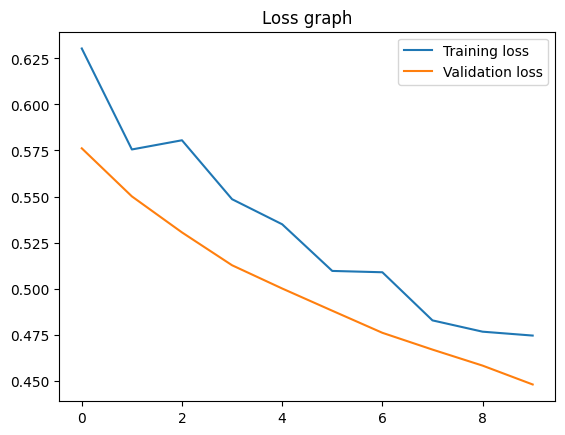

In [22]:
# Plot the graph loss and accuracy
plt.plot(history_first.history['loss'])
plt.plot(history_first.history['val_loss'])
plt.title("Loss graph")
plt.legend(['Training loss','Validation loss'])
plt.show()

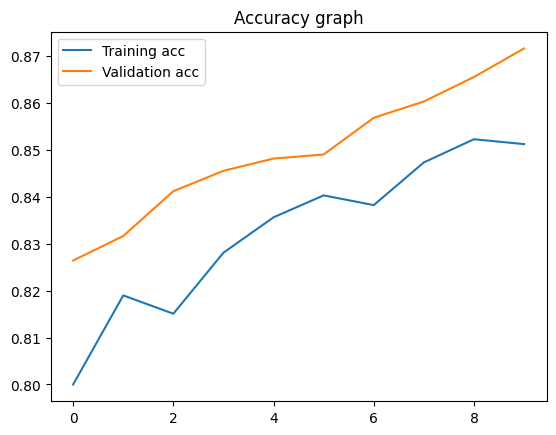

In [23]:
# Plot the accuracy graph
plt.plot(history_first.history['accuracy'])
plt.plot(history_first.history['val_accuracy'])
plt.title("Accuracy graph")
plt.legend(['Training acc','Validation acc'])
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
['Abyssinian', 'Russian Blue', 'Egyptian Mau', 'Maine Coon', 'Russian Blue', 'Sphynx', 'Maine Coon', 'Exotic Shorthair', 'Egyptian Mau', 'Siamese', 'Sphynx', 'Regdoll', 'Scottish Fold', 'Scottish Fold', 'Abyssinian', 'Maine Coon', 'Himalayan', 'Russian Blue', 'Bombay', 'Himalayan', 'Maine Coon', 'Scottish Fold', 'Egyptian Mau', 'Maine Coon', 'Himalayan', 'Russian Blue', 'Regdoll', 'Maine Coon', 'Siamese', 'Sphynx', 'Exotic Shorthair', 'Bombay']


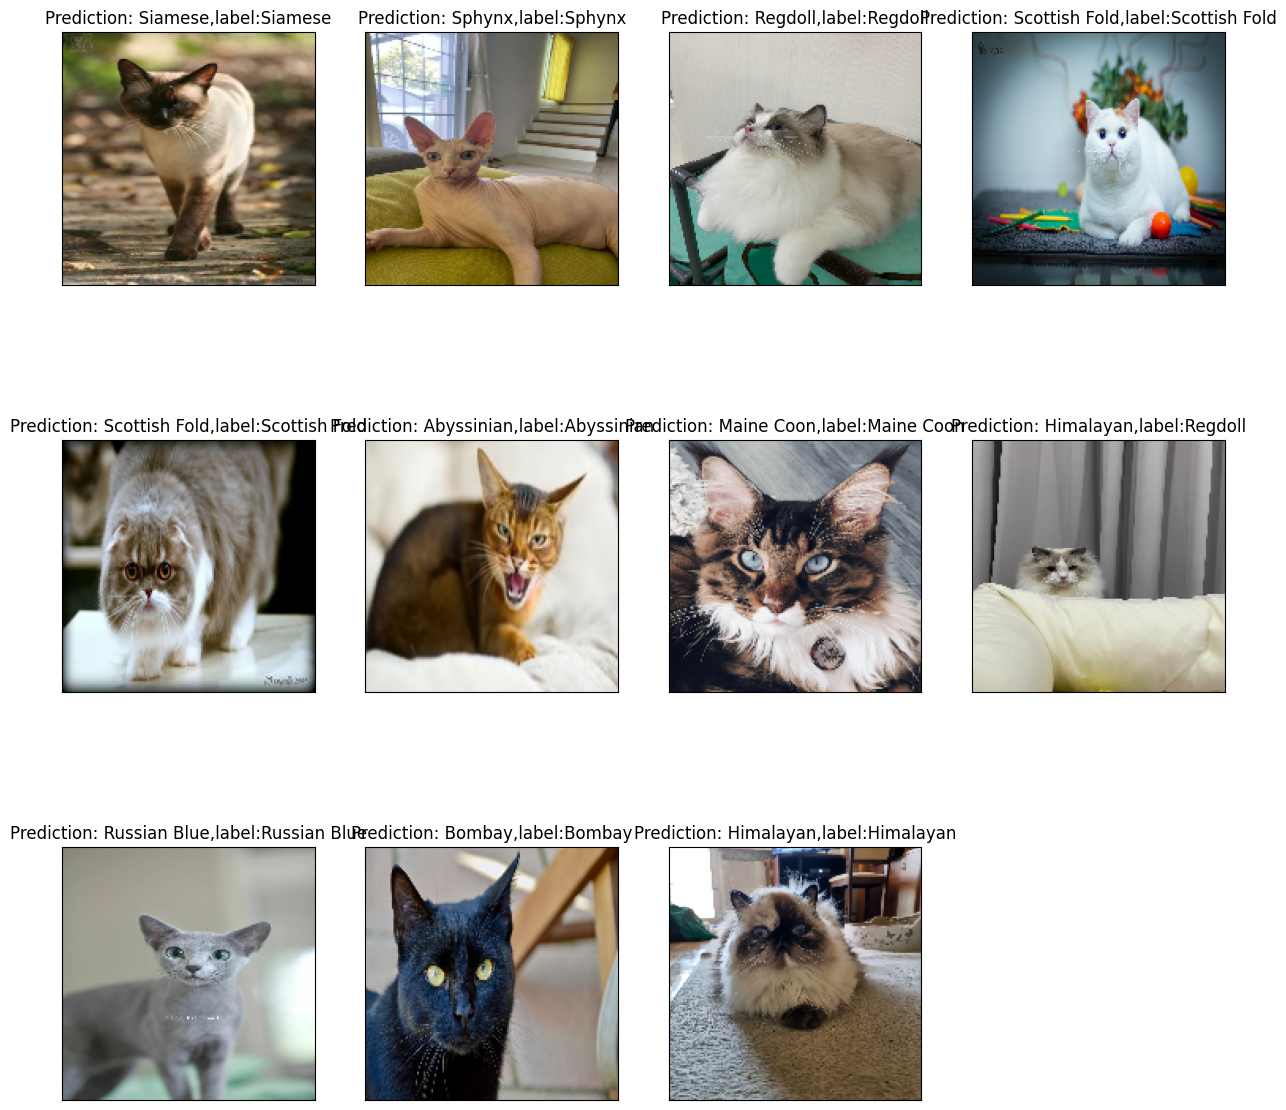

In [25]:
#Use the model to make prediction
for image_batch,label_batch in test_dataset.take(1):
    y_pred = np.argmax(model.predict(image_batch),axis=1)
    predicted_class = [class_names[x] for x in y_pred]
print(predicted_class)

plt.figure(figsize=(15,15))
for i in range(11):
    plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i+9].numpy().astype('uint8'))
    plt.title(f"Prediction: {predicted_class[i+9]},label:{class_names[label_batch[i+9]]}")
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
plt.show()

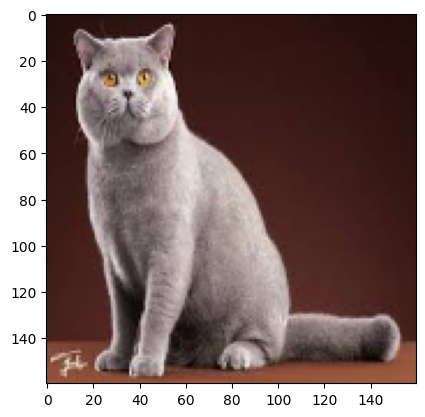

(160, 160, 3)
(1, 160, 160, 3)


In [26]:
#Use the model to predict with a random image
img = cv2.imread(filename="Cat.jpg",flags=cv2.IMREAD_COLOR_RGB)
#img = cv2.cvtColor(img,code=cv2.COLOR_BGR2BGR)
img = cv2.resize(img,dsize=(160,160))
plt.imshow(img)
plt.show()
print(img.shape)
img = np.expand_dims(img,axis=0)
print(img.shape)

In [27]:
prediction = model.predict(img)
class_names[np.argmax(prediction,axis=1)[0]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step


'Scottish Fold'

In [28]:
model.save("model.keras")